# An√°lisis de Clasificaci√≥n de Emociones en Tweets en Espa√±ol

## 1. Importaci√≥n de Librer√≠as y Configuraci√≥n Inicial

Importo todas las librer√≠as necesarias para el an√°lisis exploratorio, preprocesamiento de datos y construcci√≥n del modelo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPooling1D, Dense, Dropout,
    GlobalMaxPooling1D, LayerNormalization, Attention
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
!pip install transformers datasets accelerate -q

## 2. Descarga y Carga del Dataset EmoEvent

Descargo el dataset EmoEvent desde su repositorio de GitHub y cargo la versi√≥n en espa√±ol.

In [ ]:
import os

repo_url = "https://github.com/fmplaza/EmoEvent.git"
repo_dir = "EmoEvent"

# Descargar y descomprimir los embeddings de FastText en espa√±ol si no existen
fasttext_file = 'cc.es.300.vec'
if not os.path.exists(fasttext_file):
    print("Descargando embeddings de FastText...")
    os.system('wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz')
    print("Descomprimiendo embeddings...")
    os.system('gunzip cc.es.300.vec.gz')
else:
    print(f"El archivo de embeddings '{fasttext_file}' ya existe.")

if not os.path.exists(repo_dir):
    print(f"Clonando repositorio desde {repo_url}...")
    os.system(f"git clone {repo_url}")
else:
    print(f"El repositorio '{repo_dir}' ya existe.")

data_dir = os.path.join(repo_dir, 'splits', 'es')
files = {
    'train': os.path.join(data_dir, 'train.tsv'),
    'dev': os.path.join(data_dir, 'dev.tsv'),
    'test': os.path.join(data_dir, 'test.tsv')
}

all_files_exist = True
for split, filepath in files.items():
    if not os.path.exists(filepath):
        all_files_exist = False

if all_files_exist:
    print("Archivos del dataset listos para cargar.")

El archivo de embeddings 'cc.es.300.vec' ya existe.
El repositorio 'EmoEvent' ya existe.
Archivos del dataset listos para cargar.


In [ ]:
def load_dataset(filepath):
    df = pd.read_csv(filepath, sep='\t', header=0)
    # Corregir los nombres de las columnas que est√°n mal en el archivo original
    df.rename(columns={'tweet': 'text', 'offensive': 'is_offensive', 'emotion': 'emotion_label'}, inplace=True)
    # Reordenar y seleccionar las columnas deseadas
    df = df[['event', 'text', 'emotion_label', 'is_offensive']]
    df.columns = ['event', 'text', 'emotion', 'is_offensive']
    return df

train_df = load_dataset('EmoEvent/splits/es/train.tsv')
dev_df = load_dataset('EmoEvent/splits/es/dev.tsv')
test_df = load_dataset('EmoEvent/splits/es/test.tsv')

full_df = pd.concat([train_df, dev_df, test_df], ignore_index=True)

print(f"Dataset completo cargado:")
print(f"- Entrenamiento: {len(train_df)} tweets")
print(f"- Desarrollo: {len(dev_df)} tweets")
print(f"- Prueba: {len(test_df)} tweets")
print(f"- Total: {len(full_df)} tweets")

display(full_df.head())

Dataset completo cargado:
- Entrenamiento: 5723 tweets
- Desarrollo: 844 tweets
- Prueba: 1656 tweets
- Total: 8223 tweets


event                                               text  emotion  \
0  GameOfThrones  La Gran Guerra de #JuegoDeTronos nos ha dejado...   others   
1      Venezuela  El golpe de Estado en #Venezuela est√° m√°s lejo...   others   
2      NotreDame  No tengo una foto en la catedral de #NotreDame...  sadness   
3      NotreDame  #NotreDame nunca llegue a visitar tan grandios...  sadness   
4  GameOfThrones      A tomar por culo mi crush üò≠üò≠üò≠üò≠üò≠#JuegoDeTronos  sadness   

  is_offensive  
0           NO  
1           NO  
2           NO  
3           NO  
4          OFF

## 3. An√°lisis Exploratorio de Datos (EDA)

Realizo un an√°lisis del dataset para comprender la distribuci√≥n de emociones, eventos y caracter√≠sticas del texto.

### 3.1 Informaci√≥n General y Limpieza del Dataset

Examino la estructura del dataset, valores nulos y tipos de datos. Tambi√©n realizo una limpieza inicial.

In [ ]:
print("Forma del dataset original:", full_df.shape)
print("\nValores nulos antes de la limpieza:")
print(full_df.isnull().sum())

# Limpieza de valores nulos
full_df.dropna(inplace=True)

print("\nForma del dataset despu√©s de la limpieza:", full_df.shape)
print("\nValores nulos despu√©s de la limpieza:")
print(full_df.isnull().sum())

# Estad√≠sticas descriptivas del texto
full_df['text_length'] = full_df['text'].str.len()
full_df['word_count'] = full_df['text'].str.split().str.len()
print(full_df[['text_length', 'word_count']].describe())

# Calcular percentiles para la longitud de las secuencias
percentile_95 = int(full_df['word_count'].quantile(0.95))
percentile_99 = int(full_df['word_count'].quantile(0.99))

print(f"\nAn√°lisis de Longitud de Secuencia:")
print(f"El 95% de los tweets tienen {percentile_95} palabras o menos.")
print(f"El 99% de los tweets tienen {percentile_99} palabras o menos.")

Forma del dataset original: (8223, 4)

Valores nulos antes de la limpieza:
event           30
text            30
emotion          0
is_offensive    30
dtype: int64

Forma del dataset despu√©s de la limpieza: (8193, 4)

Valores nulos despu√©s de la limpieza:
event           0
text            0
emotion         0
is_offensive    0
dtype: int64
       text_length   word_count
count  8193.000000  8193.000000
mean    151.975589    22.403759
std      93.192072    13.551255
min      32.000000     4.000000
25%      98.000000    13.000000
50%     137.000000    20.000000
75%     198.000000    29.000000
max    5978.000000   723.000000

An√°lisis de Longitud de Secuencia:
El 95% de los tweets tienen 44 palabras o menos.
El 99% de los tweets tienen 50 palabras o menos.


### 3.2 Distribuci√≥n de Emociones

Analizo la distribuci√≥n de las categor√≠as emocionales en el dataset.

          Cantidad  Porcentaje
emotion                       
others        4010       48.94
joy           1756       21.43
sadness        992       12.11
anger          840       10.25
surprise       340        4.15
disgust        160        1.95
fear            95        1.16


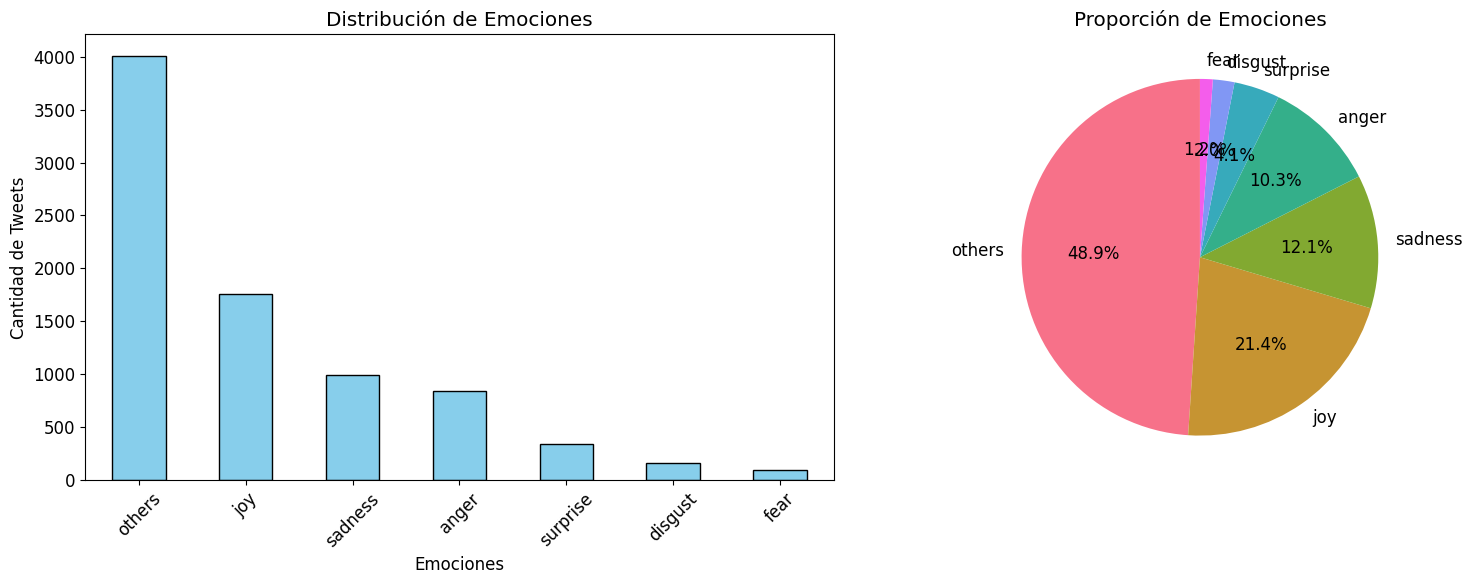

In [ ]:
emotion_counts = full_df['emotion'].value_counts()
emotion_percentages = full_df['emotion'].value_counts(normalize=True) * 100

emotion_stats = pd.DataFrame({
    'Cantidad': emotion_counts,
    'Porcentaje': emotion_percentages.round(2)
})
print(emotion_stats)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

emotion_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Distribuci√≥n de Emociones')
axes[0].set_xlabel('Emociones')
axes[0].set_ylabel('Cantidad de Tweets')
axes[0].tick_params(axis='x', rotation=45)

axes[1].pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%',
           startangle=90, colors=sns.color_palette('husl', len(emotion_counts)))
axes[1].set_title('Proporci√≥n de Emociones')

plt.tight_layout()
plt.show()

### 3.3 An√°lisis por Eventos

Exploro la distribuci√≥n de emociones por evento.

N√∫mero total de eventos √∫nicos: 8

Top 10 eventos m√°s frecuentes:
event
NotreDame          1182
GameOfThrones      1180
Venezuela          1171
ChampionsLeague    1171
SpainElection      1168
WorldBookDay       1154
GretaThunberg       611
LaLiga              556
Name: count, dtype: int64


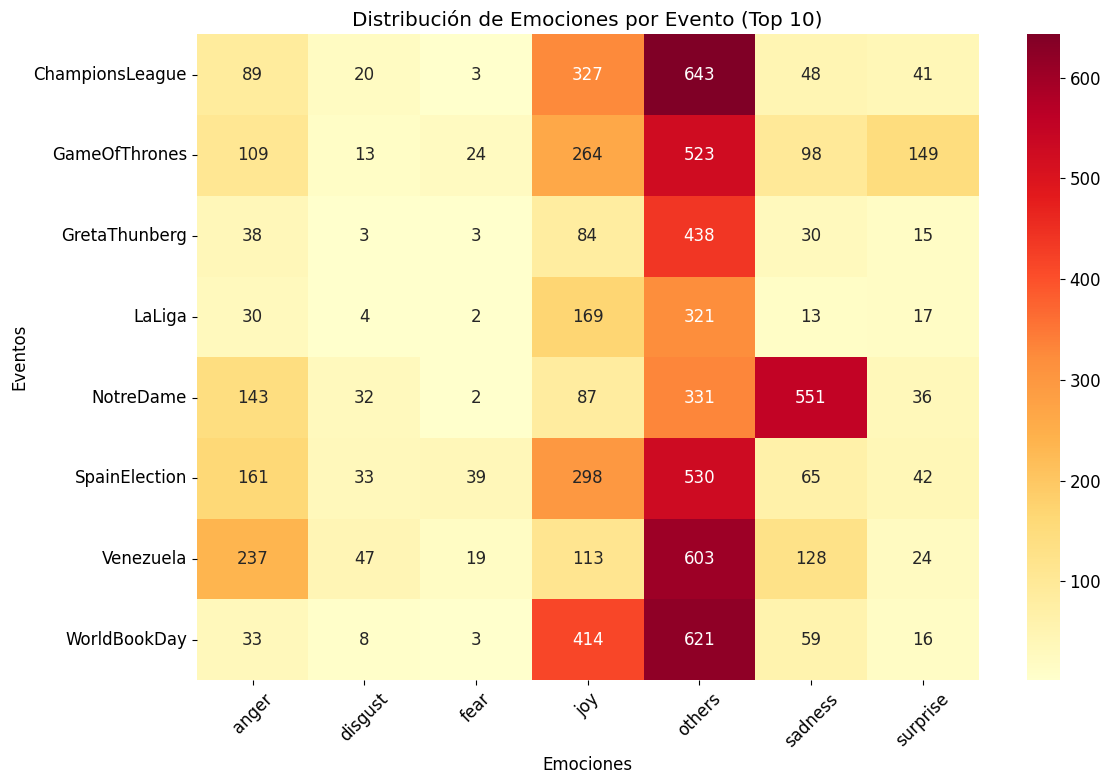

In [ ]:
event_counts = full_df['event'].value_counts()
print(f"N√∫mero total de eventos √∫nicos: {len(event_counts)}")
print("\nTop 10 eventos m√°s frecuentes:")
print(event_counts.head(10))

top_events = event_counts.head(10).index
emotion_event_matrix = pd.crosstab(full_df[full_df['event'].isin(top_events)]['event'],
                                  full_df[full_df['event'].isin(top_events)]['emotion'])

plt.figure(figsize=(12, 8))
sns.heatmap(emotion_event_matrix, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Distribuci√≥n de Emociones por Evento (Top 10)')
plt.xlabel('Emociones')
plt.ylabel('Eventos')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.4 An√°lisis de Caracter√≠sticas del Texto

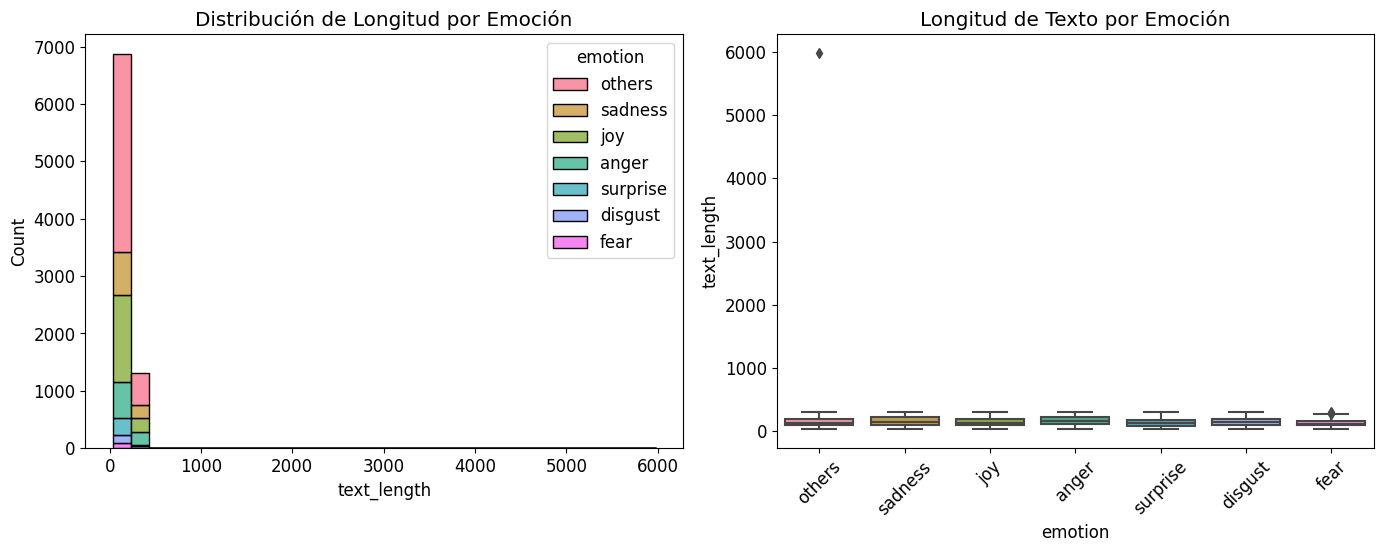

         text_length                   word_count                
                mean     std min   max       mean    std min  max
emotion                                                          
anger         169.54   72.16  34   304      26.54  12.37   4   59
disgust       158.42   64.57  32   302      23.92  10.34   6   48
fear          136.41   59.72  44   302      20.61  11.03   7   53
joy           147.21   65.68  34   304      21.63  10.74   6   57
others        148.39  112.92  34  5978      21.27  15.23   4  723
sadness       166.10   71.91  32   304      25.53  12.23   5   56
surprise      135.56   61.77  38   304      20.28  10.15   6   52


In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.histplot(data=full_df, x='text_length', hue='emotion', multiple='stack', bins=30)
plt.title('Distribuci√≥n de Longitud por Emoci√≥n')

plt.subplot(2, 2, 2)
sns.boxplot(data=full_df, x='emotion', y='text_length')
plt.xticks(rotation=45)
plt.title('Longitud de Texto por Emoci√≥n')

plt.tight_layout()
plt.show()

text_stats = full_df.groupby('emotion')[['text_length', 'word_count']].agg(['mean', 'std', 'min', 'max'])
print(text_stats.round(2))

In [ ]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

def basic_preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = ' '.join(text.split())
    return text

full_df['text_processed'] = full_df['text'].apply(basic_preprocess)
full_df_cleaned = full_df.dropna(subset=['emotion']).copy()

spanish_stopwords = set(stopwords.words('spanish'))
additional_stopwords = {'rt', 'via', 'q', 'si', 'ya', 'ser', 'estar', 'tener', 'hacer'}
spanish_stopwords.update(additional_stopwords)

def get_top_words(texts, n=20):
    all_words = []
    for text in texts:
        words = word_tokenize(text)
        words = [word for word in words if word not in spanish_stopwords and len(word) > 2]
        all_words.extend(words)
    return Counter(all_words).most_common(n)

for emotion in full_df_cleaned['emotion'].unique():
    emotion_texts = full_df_cleaned[full_df_cleaned['emotion'] == emotion]['text_processed'].tolist()
    top_words = get_top_words(emotion_texts, 10)
    print(f"\n{emotion.upper()}:")
    for word, count in top_words:
        print(f"  {word}: {count}")


OTHERS:
  user: 1572
  championsleague: 648
  venezuela: 586
  juegodetronos: 531
  elecccionesgeneralesa: 522
  gretathunberg: 443
  diadellibro: 376
  notredame: 327
  laliga: 315
  hoy: 296

SADNESS:
  notredame: 530
  user: 234
  triste: 131
  venezuela: 119
  catedral: 113
  hoy: 110
  incendio: 107
  historia: 99
  juegodetronos: 98
  p√©rdida: 96

JOY:
  user: 571
  championsleague: 325
  elecccionesgeneralesa: 285
  juegodetronos: 264
  diadellibro: 256
  mejor: 221
  messi: 216
  hoy: 189
  laliga: 164
  gracias: 161

ANGER:
  user: 382
  venezuela: 218
  elecccionesgeneralesa: 156
  notredame: 125
  juegodetronos: 111
  championsleague: 88
  mierda: 57
  puta: 57
  gente: 52
  ver: 45

SURPRISE:
  juegodetronos: 147
  user: 54
  cap√≠tulo: 52
  championsleague: 42
  elecccionesgeneralesa: 41
  gameofthrones: 40
  notredame: 34
  ver: 31
  messi: 25
  mejor: 25

DISGUST:
  user: 57
  venezuela: 42
  elecccionesgeneralesa: 32
  notredame: 31
  championsleague: 21
  ver: 15
  m

### 3.5 Visualizaci√≥n con Nubes de Palabras

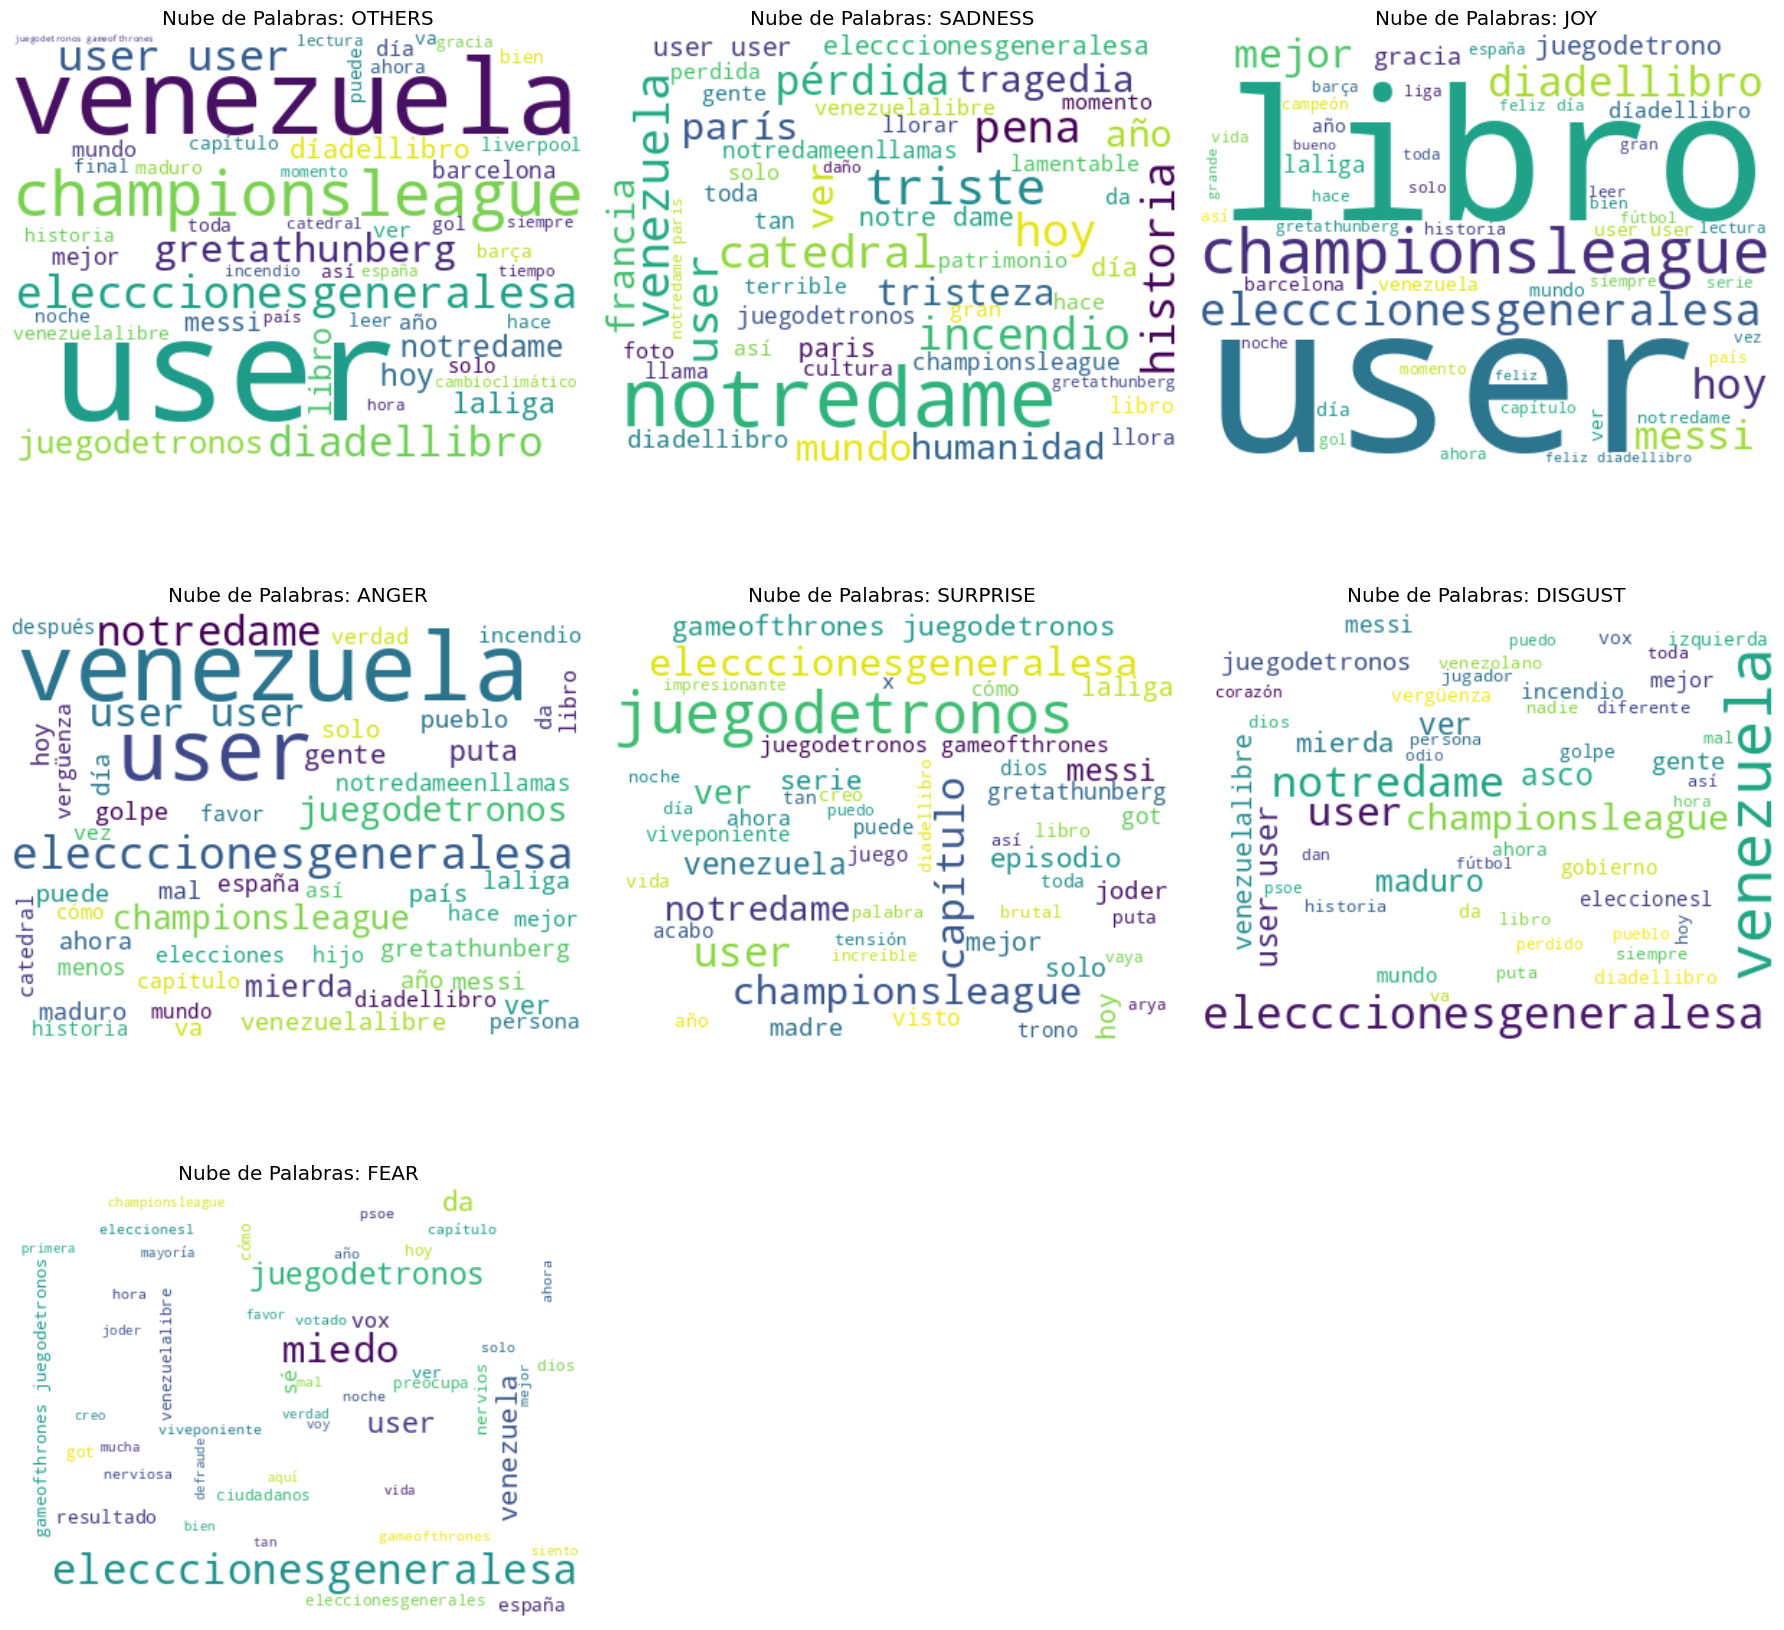

In [ ]:
emotions = full_df_cleaned['emotion'].unique()
n_emotions = len(emotions)
cols = 3
rows = (n_emotions + cols - 1) // cols

plt.figure(figsize=(18, 6 * rows))

for i, emotion in enumerate(emotions):
    plt.subplot(rows, cols, i + 1)

    emotion_texts = ' '.join(full_df_cleaned[full_df_cleaned['emotion'] == emotion]['text_processed'].dropna())

    if emotion_texts.strip():
        wordcloud = WordCloud(
            width=400, height=300,
            background_color='white',
            stopwords=spanish_stopwords,
            max_words=50,
            colormap='viridis'
        ).generate(emotion_texts)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Nube de Palabras: {emotion.upper()}')
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, f'No hay suficientes palabras para\n "{emotion.upper()}"',
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=12, color='gray')
        plt.title(f'Nube de Palabras: {emotion.upper()}')
        plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Preprocesamiento de Datos para Modelado

Preparo los datos para el entrenamiento del modelo, incluyendo tokenizaci√≥n, codificaci√≥n de etiquetas y divisi√≥n de conjuntos.

In [ ]:
from nltk.corpus import stopwords

# Definir stopwords en espa√±ol y a√±adir algunas personalizadas
spanish_stopwords = set(stopwords.words('spanish'))
# Eliminar palabras de negaci√≥n de la lista de stopwords, ya que son importantes para el sentimiento
negations = {'no', 'ni', 'ninguno', 'nada'}
spanish_stopwords = spanish_stopwords - negations
# Los tokens de marcador de posici√≥n para URL, MENTION, etc. todav√≠a son √∫tiles para eliminar
additional_stopwords = {'rt', 'via', 'q', 'si', 'ya', 'ser', 'estar', 'tener', 'hacer', 'url', 'mention', 'hashtag', 'exclamation', 'question'}
spanish_stopwords.update(additional_stopwords)

def advanced_preprocess(text):
    # Asegurarse de que el texto sea una cadena de texto antes de procesarlo
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    return text


# Combinar los dataframes de entrenamiento y desarrollo antes del preprocesamiento
train_combined = pd.concat([train_df, dev_df], ignore_index=True)


# Convertir las columnas 'text' a string y rellenar posibles valores NaN antes de aplicar el preprocesamiento
train_combined['text_clean'] = train_combined['text'].astype(str).fillna('').apply(advanced_preprocess)
test_df['text_clean'] = test_df['text'].astype(str).fillna('').apply(advanced_preprocess)

In [ ]:
test_df_cleaned = test_df.dropna(subset=['emotion']).copy()

label_encoder = LabelEncoder()
train_combined['emotion_encoded'] = label_encoder.fit_transform(train_combined['emotion'])
test_df_cleaned['emotion_encoded'] = label_encoder.transform(test_df_cleaned['emotion'])

emotion_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
num_classes = len(label_encoder.classes_)

# Feature Engineering
event_one_hot = pd.get_dummies(train_combined['event'], prefix='event')
is_offensive_feature = (train_combined['is_offensive'] == 'yes').astype(int)
additional_features = pd.concat([event_one_hot, is_offensive_feature.rename('is_offensive')], axis=1)

event_one_hot_test = pd.get_dummies(test_df_cleaned['event'], prefix='event')
is_offensive_feature_test = (test_df_cleaned['is_offensive'] == 'yes').astype(int)
additional_features_test = pd.concat([event_one_hot_test, is_offensive_feature_test.rename('is_offensive')], axis=1)

# Align columns between train and test
train_cols = additional_features.columns
test_cols = additional_features_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    additional_features_test[c] = 0
missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    additional_features[c] = 0
additional_features_test = additional_features_test[additional_features.columns]

X_train_text = train_combined['text_clean'].values
X_train_features = additional_features.values
y_train = train_combined['emotion_encoded'].values
X_test_text = test_df_cleaned['text_clean'].values
X_test_features = additional_features_test.values
y_test = test_df_cleaned['emotion_encoded'].values

X_train_text_split, X_val_text_split, X_train_features_split, X_val_features_split, y_train_split, y_val_split = train_test_split(
    X_train_text, X_train_features, y_train, test_size=0.2, random_state=42, stratify=y_train
)

## 5. Tokenizaci√≥n y Preparaci√≥n de Secuencias

In [ ]:
MAX_VOCAB_SIZE = 15000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300  # Dimensi√≥n de los embeddings de FastText

tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token='<OOV>',
    filters='',
    lower=False
)

tokenizer.fit_on_texts(X_train_text_split)

X_train_seq = tokenizer.texts_to_sequences(X_train_text_split)
X_val_seq = tokenizer.texts_to_sequences(X_val_text_split)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1

y_train_cat = tf.keras.utils.to_categorical(y_train_split, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val_split, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)


# --- Cargar Embeddings de FastText y Crear Matriz de Embeddings ---
print('Cargando vectores de palabras de FastText...')
embeddings_index = {}
with open('cc.es.300.vec', 'r', encoding='utf-8') as f:
    # La primera l√≠nea del archivo .vec contiene el n√∫mero de palabras y la dimensi√≥n
    next(f)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Se encontraron {len(embeddings_index)} vectores de palabras.')


# Crear una matriz de pesos para las palabras en el vocabulario del tokenizer
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Las palabras que no se encuentren en el √≠ndice de embeddings permanecer√°n como vectores de ceros.
            embedding_matrix[i] = embedding_vector

Cargando vectores de palabras de FastText...
Se encontraron 2000000 vectores de palabras.


## 6. Construcci√≥n del Modelo Ensemble: BiLSTM + Attention

### 6.1 Definici√≥n de la Arquitectura del Modelo

In [ ]:
from tensorflow.keras.layers import concatenate

def create_multi_input_model(vocab_size, embedding_dim, max_length, num_classes, num_additional_features):
    # Rama de entrada de texto
    input_text = Input(shape=(max_length,), name='input_text')
    embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        name='embedding'
    )(input_text)
    embedding_dropout = Dropout(0.2, name='embedding_dropout')(embedding)


    # Capa BiLSTM
    bilstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
    )(embedding_dropout)


    # Capa de Atenci√≥n
    attention = Attention(name='attention')([bilstm, bilstm])


    # Agrupaci√≥n (Pooling)
    pool = GlobalMaxPooling1D(name='maxpool')(attention)


    # Rama de entrada para caracter√≠sticas adicionales
    input_features = Input(shape=(num_additional_features,), name='input_features')

    # Concatenar caracter√≠sticas de texto con caracter√≠sticas adicionales
    concatenated = concatenate([pool, input_features])


    # Capas densas para la clasificaci√≥n
    dense1 = Dense(128, activation='relu', name='dense_1')(concatenated)
    dense1_dropout = Dropout(0.5, name='dense_dropout_1')(dense1)

    output = Dense(num_classes, activation='softmax', name='output')(dense1_dropout)

    model = Model(inputs=[input_text, input_features], outputs=output, name='BiLSTM_Attention_Features_Model')
    return model

model = create_multi_input_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes,
    num_additional_features=X_train_features.shape[1]
)
model.summary()

I0000 00:00:1756758959.524994    4028 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "BiLSTM_Attention_Features_Model"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_text          ‚îÇ (None, 50)        ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding           ‚îÇ (None, 50, 300)   ‚îÇ  7,179,600 ‚îÇ input_text[0][0]  ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_dropout   ‚îÇ (None, 50, 300)   ‚îÇ          0 ‚îÇ embedding[0][0]   ‚îÇ
‚îÇ (Dropout)           ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional       ‚îÇ (None, 50, 256)   ‚îÇ    439,296 ‚îÇ embedding_dropou‚Ä¶ ‚îÇ
‚îÇ (Bidirectional)     ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ attention           ‚îÇ (None, 50, 256)   ‚îÇ          0 ‚îÇ bidirectional[0]‚Ä¶ ‚îÇ
‚îÇ (Attention)         ‚îÇ                   ‚îÇ            ‚îÇ bidirectional[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ maxpool             ‚îÇ (None, 256)       ‚îÇ          0 ‚îÇ attention[0][0]   ‚îÇ
‚îÇ (GlobalMaxPooling1‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_features      ‚îÇ (None, 9)         ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate         ‚îÇ (None, 265)       ‚îÇ          0 ‚îÇ maxpool[0][0],    ‚îÇ
‚îÇ (Concatenate)       ‚îÇ                   ‚îÇ            ‚îÇ input_features[0‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)     ‚îÇ (None, 128)       ‚îÇ     34,048 ‚îÇ concatenate[0][0] ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚î

 Total params: 7,653,847 (29.20 MB)

 Trainable params: 474,247 (1.81 MB)

 Non-trainable params: 7,179,600 (27.39 MB)

### 6.2 Compilaci√≥n del Modelo

In [ ]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]

# --- Manejo de Desbalance de Clases con Class Weight ---
class_weights_dict = {0: 1.4, 1: 3.0, 2: 4.0, 3: 0.7, 4: 0.5, 5: 1.2, 6: 2.0}

print("Pesos de clase definidos manualmente:")
print(class_weights_dict)

Pesos de clase definidos manualmente:
{0: 1.4, 1: 3.0, 2: 4.0, 3: 0.7, 4: 0.5, 5: 1.2, 6: 2.0}


### 6.3 Entrenamiento del Modelo

In [ ]:
from sklearn.model_selection import StratifiedKFold

BATCH_SIZE = 100
EPOCHS = 30
N_SPLITS = 5

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

histories = []
scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_text, y_train)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")

    # Dividir los datos para este fold
    X_train_text_fold = X_train_text[train_idx]
    X_val_text_fold = X_train_text[val_idx]
    X_train_features_fold = X_train_features[train_idx].astype(np.float32)
    X_val_features_fold = X_train_features[val_idx].astype(np.float32)
    y_train_fold = y_train[train_idx]
    y_val_fold = y_train[val_idx]


    # Tokenizar y rellenar los datos de texto para este fold
    tokenizer.fit_on_texts(X_train_text_fold)
    X_train_seq_fold = tokenizer.texts_to_sequences(X_train_text_fold)
    X_val_seq_fold = tokenizer.texts_to_sequences(X_val_text_fold)
    X_train_pad_fold = pad_sequences(X_train_seq_fold, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    X_val_pad_fold = pad_sequences(X_val_seq_fold, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')


    # Convertir etiquetas a formato categ√≥rico
    y_train_cat_fold = tf.keras.utils.to_categorical(y_train_fold, num_classes)
    y_val_cat_fold = tf.keras.utils.to_categorical(y_val_fold, num_classes)


    # Crear y compilar el modelo
    model = create_multi_input_model(
        vocab_size=vocab_size,
        embedding_dim=EMBEDDING_DIM,
        max_length=MAX_SEQUENCE_LENGTH,
        num_classes=num_classes,
        num_additional_features=X_train_features.shape[1]
    )
    model.compile(optimizer=Adam(learning_rate=0.001), loss=focal_loss(), metrics=['accuracy'])


    # Entrenar el modelo
    history = model.fit(
        [X_train_pad_fold, X_train_features_fold],
        y_train_cat_fold,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=([X_val_pad_fold, X_val_features_fold], y_val_cat_fold),
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=1
    )
    histories.append(history)


    # Evaluar en el conjunto de prueba
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    y_pred_proba = model.predict([X_test_pad, X_test_features.astype(np.float32)], batch_size=BATCH_SIZE, verbose=0) # Convertir a float32
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)
    scores.append(report)


# --- Agregar y Mostrar Resultados ---
avg_accuracy = np.mean([s['accuracy'] for s in scores])
avg_precision = np.mean([s['weighted avg']['precision'] for s in scores])
avg_recall = np.mean([s['weighted avg']['recall'] for s in scores])
avg_f1 = np.mean([s['weighted avg']['f1-score'] for s in scores])

print("\n--- Cross-Validation Results ---")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Weighted Precision: {avg_precision:.4f}")
print(f"Average Weighted Recall: {avg_recall:.4f}")
print(f"Average Weighted F1-Score: {avg_f1:.4f}")

--- Fold 1/5 ---
Epoch 1/30
53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24s 217ms/step - accuracy: 0.3772 - loss: 0.0380 - val_accuracy: 0.5259 - val_loss: 0.0345
Epoch 2/30
53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 179ms/step - accuracy: 0.5098 - loss: 0.0304 - val_accuracy: 0.5449 - val_loss: 0.0329
Epoch 3/30
53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 179ms/step - accuracy: 0.5251 - loss: 0.0291 - val_accuracy: 0.5693 - val_loss: 0.0320
Epoch 4/30
53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 179ms/step - accuracy: 0.5499 - loss: 0.0281 - val_accuracy: 0.5769 - val_loss: 0.0313
Epoch 5/30
53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 181ms/step - accuracy: 0.5552 - loss: 0.0278 - val_accuracy: 0.5784 - val_loss: 0.0309
Epoch 6/30
53/53 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 183ms/step - accuracy: 0.5646 - loss: 0.0274 - val_accura

## 7. Modelo 2: DeBERTa-v3 con Fine-tuning Avanzado

Ahora, implementaremos un modelo de Transformer de √∫ltima generaci√≥n, DeBERTa-v3, y lo afinaremos para nuestra tarea de clasificaci√≥n de emociones.

### 7.1 Preparaci√≥n de Datos y Tokenizaci√≥n para DeBERTa

Para utilizar un modelo de Transformer como DeBERTa, primero debemos preparar los datos en un formato que la librer√≠a `transformers` pueda entender. Esto implica:
1.  **Cargar el Tokenizador**: Cada modelo Transformer tiene un tokenizador espec√≠fico que fue usado durante su pre-entrenamiento. Usamos `AutoTokenizer` para cargar el tokenizador correspondiente a `microsoft/deberta-v3-base`.
2.  **Crear un Dataset de Hugging Face**: Convertimos nuestros DataFrames de pandas a objetos `Dataset` de la librer√≠a `datasets`. Esto facilita la tokenizaci√≥n y el entrenamiento.
3.  **Tokenizar el Texto**: Creamos una funci√≥n `tokenize_function` que aplica el tokenizador a nuestros textos. Esta funci√≥n convierte el texto en IDs num√©ricos, a√±ade tokens especiales (`[CLS]`, `[SEP]`), y trunca o rellena las secuencias a una longitud fija (`MAX_SEQUENCE_LENGTH`).
4.  **Formatear el Dataset**: Renombramos la columna de etiquetas a `labels`, que es el nombre que espera el `Trainer` de Hugging Face. Tambi√©n dividimos el conjunto de entrenamiento en un nuevo subconjunto de entrenamiento y uno de validaci√≥n para monitorear el rendimiento del modelo durante el fine-tuning.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, ClassLabel
import numpy as np

# Comprobar si la GPU est√° disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

MODEL_NAME = 'microsoft/deberta-v3-base'


# Cargar tokenizador
deberta_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


# Usaremos el texto previamente limpiado
train_dataset_hf = Dataset.from_pandas(train_combined[['text_clean', 'emotion_encoded']])
test_dataset_hf = Dataset.from_pandas(test_df_cleaned[['text_clean', 'emotion_encoded']])


# Funci√≥n de tokenizaci√≥n
def tokenize_function(examples):
    return deberta_tokenizer(examples['text_clean'], padding='max_length', truncation=True, max_length=MAX_SEQUENCE_LENGTH)


# Aplicar tokenizaci√≥n
train_tokenized_dataset = train_dataset_hf.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset_hf.map(tokenize_function, batched=True)


# Renombrar la columna para que coincida con la entrada esperada del modelo
train_tokenized_dataset = train_tokenized_dataset.rename_column("emotion_encoded", "labels")
test_tokenized_dataset = test_tokenized_dataset.rename_column("emotion_encoded", "labels")


# Convertir la columna de etiquetas a ClassLabel para la estratificaci√≥n
class_names = label_encoder.classes_.tolist()
num_classes_deberta = len(class_names)
train_tokenized_dataset = train_tokenized_dataset.cast_column("labels", ClassLabel(num_classes=num_classes_deberta, names=class_names))
test_tokenized_dataset = test_tokenized_dataset.cast_column("labels", ClassLabel(num_classes=num_classes_deberta, names=class_names))


# Dividir los datos de entrenamiento en conjuntos de entrenamiento y validaci√≥n
train_val_split = train_tokenized_dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column="labels")
train_dataset_deberta = train_val_split['train']
val_dataset_deberta = train_val_split['test']

print("Data prepared for DeBERTa model.")
print(f"Train dataset size: {len(train_dataset_deberta)}")
print(f"Validation dataset size: {len(val_dataset_deberta)}")
print(f"Test dataset size: {len(test_tokenized_dataset)}")

Using device: cuda


Map:   0%|          | 0/6567 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6567 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1656 [00:00<?, ? examples/s]

Data prepared for DeBERTa model.
Train dataset size: 5253
Validation dataset size: 1314
Test dataset size: 1656


### 7.2 Configuraci√≥n del Entrenamiento y Fine-Tuning

Una vez que los datos est√°n listos, configuramos y ejecutamos el proceso de fine-tuning:
1.  **Cargar el Modelo**: Usamos `AutoModelForSequenceClassification` para cargar el modelo DeBERTa pre-entrenado. Le especificamos el n√∫mero de etiquetas de nuestro problema y le pasamos los mapeos `id2label` y `label2id` para que el modelo entienda la relaci√≥n entre los IDs y los nombres de las emociones.
2.  **Definir los Argumentos de Entrenamiento**: `TrainingArguments` es una clase que nos permite configurar todos los aspectos del entrenamiento, como el directorio de salida, el n√∫mero de √©pocas, el tama√±o del lote, la tasa de aprendizaje, y las estrategias de evaluaci√≥n y guardado.
3.  **Definir la M√©trica de Evaluaci√≥n**: Creamos la funci√≥n `compute_metrics` para calcular el F1-score, la precisi√≥n y el recall durante la evaluaci√≥n. Esto nos permite monitorear el rendimiento del modelo de forma m√°s completa que solo con la accuracy.
4.  **Crear el Trainer**: El objeto `Trainer` de Hugging Face centraliza todo el proceso de entrenamiento. Le pasamos el modelo, los argumentos, los datasets de entrenamiento y validaci√≥n, y la funci√≥n de m√©tricas.
5.  **Entrenar**: Finalmente, llamamos al m√©todo `trainer.train()` para iniciar el fine-tuning del modelo con nuestros datos.

In [ ]:
# Ejecuta esta celda primero
import os
from huggingface_hub import logout

# Desconectarse completamente
try:
    logout()
    print("Desconectado de Hugging Face Hub")
except:
    print("No estaba conectado")

# Configurar variables de entorno para modo offline
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_DATASETS_OFFLINE"] = "1"

print("Modo offline configurado")

Not logged in!


Desconectado de Hugging Face Hub
Modo offline configurado


In [ ]:
# Configurar modo offline y desactivar todas las conexiones
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_DATASETS_OFFLINE"] = "1"
os.environ["WANDB_DISABLED"] = "true"

# Limpiar espacio en disco antes de entrenar
import shutil
import tempfile

def cleanup_disk_space():
    """Limpia archivos temporales y checkpoints antiguos para liberar espacio"""
    # Limpiar directorio temporal
    temp_dir = tempfile.gettempdir()
    print(f"Limpiando directorio temporal: {temp_dir}")

    # Eliminar directorios de resultados anteriores si existen
    dirs_to_clean = ['./results_deberta', './logs_deberta', './checkpoints']
    for dir_path in dirs_to_clean:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
            print(f"Eliminado: {dir_path}")

    # Verificar espacio disponible
    total, used, free = shutil.disk_usage("./")
    print(f"Espacio libre: {free // (2**30)} GB")
    return free // (2**30)  # Retorna GB libres

# Ejecutar limpieza
free_gb = cleanup_disk_space()
if free_gb < 2:
    print("‚ö†Ô∏è  ADVERTENCIA: Poco espacio libre en disco. Considera liberar m√°s espacio.")

# Crear mappings con tipos nativos de Python usando label_encoder
id2label = {int(i): str(label) for i, label in enumerate(label_encoder.classes_)}
label2id = {str(label): int(i) for i, label in enumerate(label_encoder.classes_)}

# Load model sin par√°metros de configuraci√≥n que puedan causar problemas
try:
    model_deberta = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_classes_deberta,
        local_files_only=True,
        use_auth_token=False
    ).to(device)

    # Configurar los labels despu√©s de cargar el modelo
    model_deberta.config.id2label = id2label
    model_deberta.config.label2id = label2id

except Exception as e:
    print(f"Error cargando modelo: {e}")
    # Intentar sin local_files_only si falla
    model_deberta = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_classes_deberta,
        use_auth_token=False
    ).to(device)

    model_deberta.config.id2label = id2label
    model_deberta.config.label2id = label2id

# Argumentos de entrenamiento optimizados para reducir uso de disco
training_args = TrainingArguments(
    output_dir='./results_deberta',
    num_train_epochs=4,
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Reducido de 32 a 16
    per_device_eval_batch_size=16,   # Reducido de 32 a 16
    gradient_accumulation_steps=4,   # Aumentado de 2 a 4 para compensar batch size menor
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_deberta',
    logging_steps=50,  # Reducir frecuencia de logging
    eval_strategy="epoch",
    save_strategy="no",  # CAMBIO CLAVE: No guardar checkpoints intermedios
    # save_steps=1000,   # Comentado porque save_strategy="no"
    # save_total_limit=1,  # Comentado porque save_strategy="no"
    load_best_model_at_end=False,  # CAMBIO: Deshabilitado para ahorrar espacio
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=False,
    lr_scheduler_type='cosine',
    dataloader_num_workers=0,  # Reducir workers para ahorrar memoria
    save_safetensors=False,    # CAMBIO: Usar formato pickle en lugar de safetensors
    report_to=None,  # CAMBIO: Reemplaza el deprecated WANDB_DISABLED
)

# Funci√≥n de m√©tricas
def compute_metrics(eval_pred):
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Entrenador
trainer = Trainer(
    model=model_deberta,
    args=training_args,
    train_dataset=train_dataset_deberta,
    eval_dataset=val_dataset_deberta,
    compute_metrics=compute_metrics,
)

# Entrenar el modelo
print("Starting DeBERTa model training...")
print("‚ö†Ô∏è  Nota: Los checkpoints intermedios est√°n deshabilitados para ahorrar espacio")

try:
    trainer.train()
    print("Training finished successfully!")

    # Guardar solo el modelo final
    final_model_path = './final_deberta_model'
    trainer.save_model(final_model_path)
    print(f"Modelo final guardado en: {final_model_path}")

except Exception as e:
    print(f"Error durante el entrenamiento: {e}")
    # Intentar liberar memoria y guardar el estado actual
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    print("Memoria GPU liberada")

# Opcional: Verificar espacio final
total, used, free = shutil.disk_usage("./")
print(f"Espacio libre final: {free // (2**30)} GB")

Limpiando directorio temporal: /tmp
Eliminado: ./results_deberta
Espacio libre: 4 GB


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting DeBERTa model training...
‚ö†Ô∏è  Nota: Los checkpoints intermedios est√°n deshabilitados para ahorrar espacio


Training finished successfully!
Modelo final guardado en: ./final_deberta_model
Espacio libre final: 4 GB


### 7.3 Evaluaci√≥n del Modelo DeBERTa

Una vez que el modelo ha sido entrenado, lo evaluamos en el conjunto de prueba para medir su rendimiento en datos no vistos:
1.  **Predicciones**: Usamos  para generar las predicciones sobre el conjunto de prueba.
2.  **Reporte de Clasificaci√≥n**: Mostramos un reporte de clasificaci√≥n detallado que incluye la precisi√≥n, el recall y el F1-score para cada emoci√≥n. Esto nos da una visi√≥n clara de c√≥mo se comporta el modelo para cada clase.
3.  **Matriz de Confusi√≥n**: Visualizamos una matriz de confusi√≥n normalizada. Esta matriz nos ayuda a identificar qu√© emociones el modelo tiende a confundir entre s√≠. Por ejemplo, si el modelo confunde a menudo  con .

Evaluating DeBERTa model on the test set...


\n--- Classification Report for DeBERTa ---
              precision    recall  f1-score   support

       anger       0.15      0.23      0.18       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.25      0.23      0.24       354
      others       0.50      0.52      0.51       814
     sadness       0.14      0.16      0.15       199
    surprise       0.00      0.00      0.00        67

    accuracy                           0.35      1656
   macro avg       0.15      0.16      0.15      1656
weighted avg       0.33      0.35      0.34      1656



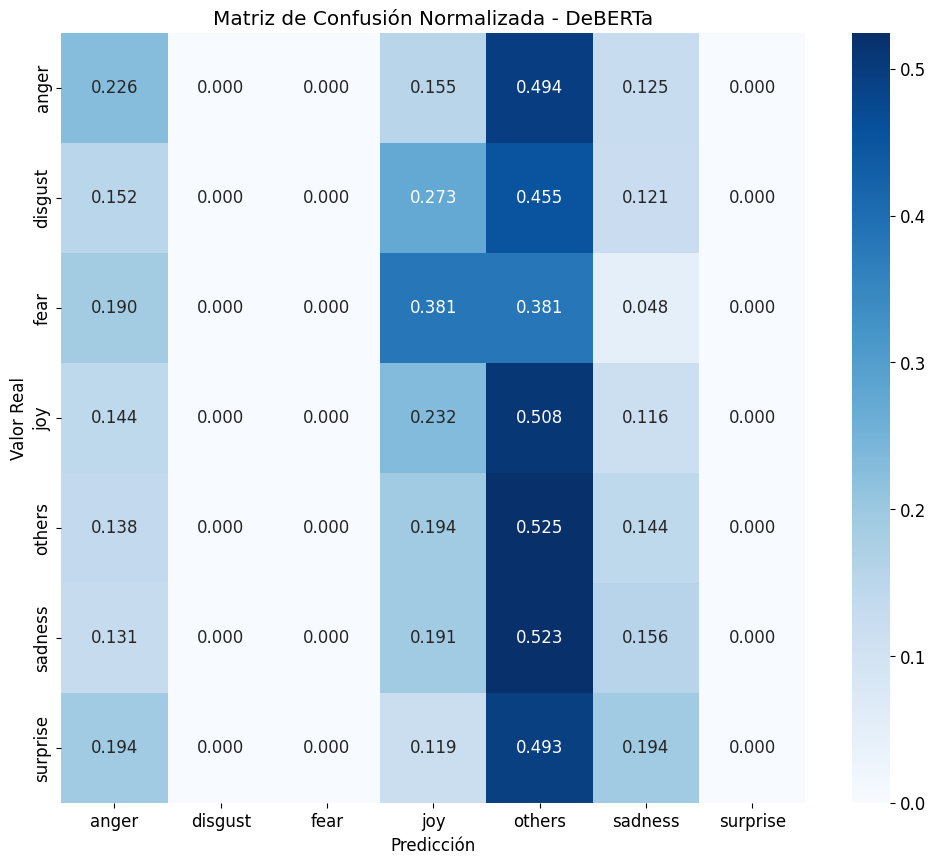

In [ ]:
# Evaluar en el conjunto de prueba
print("Evaluating DeBERTa model on the test set...")
test_results_deberta = trainer.predict(test_tokenized_dataset)


# Imprimir el informe de clasificaci√≥n
y_true_deberta = test_tokenized_dataset['labels']
y_pred_deberta = np.argmax(test_results_deberta.predictions, axis=-1)
emotion_names = list(label_encoder.classes_)

print("\\n--- Classification Report for DeBERTa ---")
print(classification_report(y_true_deberta, y_pred_deberta, target_names=emotion_names))


# Graficar la matriz de confusi√≥n
cm_deberta = confusion_matrix(y_true_deberta, y_pred_deberta)
cm_normalized_deberta = cm_deberta.astype('float') / cm_deberta.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized_deberta, annot=True, fmt='.3f', cmap='Blues', xticklabels=emotion_names, yticklabels=emotion_names)
plt.title('Matriz de Confusi√≥n Normalizada - DeBERTa')
plt.xlabel('Predicci√≥n')
plt.ylabel('Valor Real')
plt.show()

In [ ]:
# Realizar an√°lisis por evento para DeBERTa
test_results_df_deberta = test_df_cleaned.copy()
test_results_df_deberta['predicted_emotion'] = label_encoder.inverse_transform(y_pred_deberta)
test_results_df_deberta['correct_prediction'] = (test_results_df_deberta['emotion'] == test_results_df_deberta['predicted_emotion'])

event_performance_deberta = test_results_df_deberta.groupby('event')['correct_prediction'].agg(['count', 'sum', 'mean']).round(4)
event_performance_deberta.columns = ['total_tweets', 'correct_predictions', 'accuracy']
event_performance_deberta = event_performance_deberta.sort_values('accuracy', ascending=False)

significant_events_deberta = event_performance_deberta[event_performance_deberta['total_tweets'] >= 2]

if not significant_events_deberta.empty:
    print("=== RENDIMIENTO POR EVENTO (‚â•2 tweets) - DeBERTa ===")
    print(f"Eventos analizados: {len(significant_events_deberta)}")
    display(significant_events_deberta)
else:
    print("No hay eventos con 2 o m√°s tweets en el conjunto de prueba para un an√°lisis significativo.")

## 8. Modelo 3: Instruction-Tuning de un LLM (Flan-T5)

Para el tercer modelo, exploraremos el fine-tuning de un Large Language Model (LLM) que ha sido pre-entrenado con instrucciones. Usaremos `google/flan-t5-base`. La idea es formatear nuestras muestras de entrenamiento como instrucciones que el modelo debe seguir.

### 8.1 Preparaci√≥n de Datos para Flan-T5

Para el fine-tuning de un modelo Seq2Seq como Flan-T5, el enfoque es diferente:
1.  **Creaci√≥n de Prompts**: En lugar de solo pasar el texto, lo formateamos como una instrucci√≥n. Por ejemplo: `"Clasifica la emoci√≥n en este texto: [texto del tweet]"`. La etiqueta (la emoci√≥n) se convierte en el texto que el modelo debe generar.
2.  **Tokenizaci√≥n Separada**: A diferencia de un modelo de clasificaci√≥n est√°ndar, aqu√≠ tokenizamos tanto la entrada (el prompt) como la salida (la etiqueta de emoci√≥n) de forma separada, ya que el modelo aprende a generar la etiqueta como una secuencia de texto.
3.  **Dataset Instruccional**: Creamos un nuevo `Dataset` donde cada muestra contiene el prompt tokenizado como `input_ids` y la etiqueta tokenizada como `labels`.

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import Dataset

LLM_MODEL_NAME = 'google/flan-t5-base'


# Cargar tokenizador y modelo
llm_tokenizer = T5Tokenizer.from_pretrained(LLM_MODEL_NAME)
llm_model = T5ForConditionalGeneration.from_pretrained(LLM_MODEL_NAME).to(device)


# CORRECCI√ìN: Se usa un prompt m√°s simple y directo para T5
def create_instructional_dataset(df):
    instructions = []
    for _, row in df.iterrows():
        text = row['text_clean']
        emotion = row['emotion']
        # T5 funciona mejor con prompts cortos y directos
        prompt = f"Classify emotion: {text}"
        instructions.append({'text': prompt, 'label': emotion})
    return Dataset.from_list(instructions)

train_instruction_dataset = create_instructional_dataset(train_combined)
test_instruction_dataset = create_instructional_dataset(test_df_cleaned)


# CORRECCI√ìN: Tokenizaci√≥n mejorada y m√°s robusta
def tokenize_t5(examples):
    # Tokenizar la entrada de texto
    model_inputs = llm_tokenizer(
        examples['text'],
        max_length=64,
        padding=False,
        truncation=True,
        return_tensors=None
    )


    # Tokenizar las etiquetas
    with llm_tokenizer.as_target_tokenizer():
        labels = llm_tokenizer(
            examples['label'],
            max_length=8,
            padding=False,
            truncation=True,
        return_tensors=None
        )


    # Asegurarse de que las etiquetas (labels) tengan la estructura correcta
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


# Aplicar la tokenizaci√≥n
train_tokenized_t5 = train_instruction_dataset.map(
    tokenize_t5,
    batched=True,
    remove_columns=train_instruction_dataset.column_names
)

test_tokenized_t5 = test_instruction_dataset.map(
    tokenize_t5,
    batched=True,
    remove_columns=train_instruction_dataset.column_names
)


# Dividir el conjunto de entrenamiento en entrenamiento y validaci√≥n
train_val_split_t5 = train_tokenized_t5.train_test_split(test_size=0.2, seed=42)
train_dataset_t5 = train_val_split_t5['train']
val_dataset_t5 = train_val_split_t5['test']

print("Data prepared for Flan-T5 model.")
print(f"Train dataset size: {len(train_dataset_t5)}")
print(f"Validation dataset size: {len(val_dataset_t5)}")
print(f"Test dataset size: {len(test_tokenized_t5)}")


# Verificar algunas muestras tokenizadas
print("\n--- Verificaci√≥n de muestras tokenizadas ---")
for i in range(2):
    sample = train_dataset_t5[i]
    print(f"Ejemplo {i+1}:")
    print(f"Input IDs shape: {len(sample['input_ids'])}")
    print(f"Labels shape: {len(sample['labels'])}")
    print(f"Input text (decoded): {llm_tokenizer.decode(sample['input_ids'], skip_special_tokens=True)}")
    print(f"Label text (decoded): {llm_tokenizer.decode(sample['labels'], skip_special_tokens=True)}")
    print("-" * 50)

Map:   0%|          | 0/6567 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Data prepared for Flan-T5 model.
Train dataset size: 5253
Validation dataset size: 1314
Test dataset size: 1656

--- Verificaci√≥n de muestras tokenizadas ---
Ejemplo 1:
Input IDs shape: 64
Labels shape: 2
Input text (decoded): Classify emotion: tantas formas de disfrutar un buen libro. cu√°l es tu favorito? #dadellibro #somosdalia https://t.co/rk8bvb9
Label text (decoded): others
--------------------------------------------------
Ejemplo 2:
Input IDs shape: 38
Labels shape: 2
Input text (decoded): Classify emotion: qur golazo la puta madre que lo pari√≥ #championsxespn #championsleague #messi
Label text (decoded): others
--------------------------------------------------


### 8.2 Entrenamiento del Modelo Flan-T5

El entrenamiento de Flan-T5 se configura de manera similar a DeBERTa, pero con algunas consideraciones clave:
1.  **Data Collator**: Usamos `DataCollatorForSeq2Seq`, que est√° dise√±ado espec√≠ficamente para modelos de este tipo. Se encarga de rellenar din√°micamente tanto las entradas como las etiquetas de cada lote a la longitud m√°xima de ese lote, lo cual es m√°s eficiente.
2.  **Argumentos de Entrenamiento**: Ajustamos los hiperpar√°metros, como un `learning_rate` y un `batch_size` m√°s peque√±os, que suelen ser necesarios para el fine-tuning de LLMs m√°s grandes y sensibles.
3.  **M√©trica de Evaluaci√≥n**: Para los modelos Seq2Seq, se suele monitorear la `eval_loss` (p√©rdida de evaluaci√≥n) para seleccionar el mejor modelo, ya que calcular m√©tricas como el F1-score en cada paso de evaluaci√≥n es m√°s complejo y computacionalmente costoso.

In [ ]:
from transformers import TrainingArguments
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from torch import nn

# CORRECCI√ìN: TrainingArguments y m√©tricas
training_args_t5 = TrainingArguments(
    output_dir='./results_t5_improved',
    eval_strategy='steps',
    eval_steps=100,
    save_steps=500,
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=6,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-5,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model='f1_score',
    greater_is_better=True,
    push_to_hub=False,
    report_to=None,
    seed=42,
    lr_scheduler_type='cosine',
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from transformers import DataCollatorForSeq2Seq, Trainer
import torch
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from torch.utils.data import DataLoader
from torch.optim import AdamW

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Para tareas de generaci√≥n como Flan-T5, las predicciones son logits
    # Necesitamos obtener los tokens con mayor probabilidad
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Convertir logits a IDs de tokens tomando el argmax
    predicted_ids = np.argmax(predictions, axis=-1)

    # Decodificar las predicciones
    decoded_preds = llm_tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

    # Preparar las etiquetas para decodificaci√≥n
    # Reemplazar -100 (que se usa para ignorar tokens en la p√©rdida) con pad_token_id
    labels = np.where(labels != -100, labels, llm_tokenizer.pad_token_id)
    decoded_labels = llm_tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Limpiar las predicciones y etiquetas
    decoded_preds_clean = [pred.strip().lower() for pred in decoded_preds]
    decoded_labels_clean = [label.strip().lower() for label in decoded_labels]

    # Calcular m√©tricas
    try:
        f1 = f1_score(decoded_labels_clean, decoded_preds_clean, average='weighted', zero_division=0)
        precision = precision_score(decoded_labels_clean, decoded_preds_clean, average='weighted', zero_division=0)
        recall = recall_score(decoded_labels_clean, decoded_preds_clean, average='weighted', zero_division=0)
        accuracy = accuracy_score(decoded_labels_clean, decoded_preds_clean)
    except Exception as e:
        print(f"Error calculando m√©tricas: {e}")
        print(f"Primeras 5 predicciones: {decoded_preds_clean[:5]}")
        print(f"Primeras 5 etiquetas: {decoded_labels_clean[:5]}")
        # Valores por defecto si hay error
        f1 = precision = recall = accuracy = 0.0

    return {
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    }

# Data collator para seq2seq
data_collator = DataCollatorForSeq2Seq(
    tokenizer=llm_tokenizer,
    model=llm_model,
    label_pad_token_id=-100,
    padding=True,
    return_tensors="pt"
)

# Configurar el trainer
trainer_t5 = Trainer(
    model=llm_model,
    args=training_args_t5,
    train_dataset=train_dataset_t5,
    eval_dataset=val_dataset_t5,
    data_collator=data_collator,
    tokenizer=llm_tokenizer,
    compute_metrics=compute_metrics
)

# Verificar formato de datos
print("Verificando formato de datos...")
sample_batch = [train_dataset_t5[i] for i in range(2)]
try:
    collated = data_collator(sample_batch)
    print("‚úì Data collator funciona correctamente")
    print(f"Batch input_ids shape: {collated['input_ids'].shape}")
    print(f"Batch labels shape: {collated['labels'].shape}")

    # Verificar que no haya problemas con los datos
    print(f"Ejemplo input_ids: {collated['input_ids'][0][:10]}...")  # Primeros 10 tokens
    print(f"Ejemplo labels: {collated['labels'][0][:10]}...")        # Primeros 10 labels

except Exception as e:
    print(f"‚úó Error en data collator: {e}")
    raise e

print("Iniciando entrenamiento del modelo Flan-T5...")

try:
    trainer_t5.train()
    print("Entrenamiento completado. Guardando modelo...")
    trainer_t5.save_model('./flan_t5_emotion_classifier')
    print("Modelo guardado exitosamente.")

except Exception as e:
    print(f"Error durante el entrenamiento: {e}")
    # Guardar el modelo parcialmente entrenado
    print("Guardando modelo parcialmente entrenado...")
    trainer_t5.save_model('./flan_t5_emotion_classifier_partial')
    raise e

Verificando formato de datos...
‚úì Data collator funciona correctamente
Batch input_ids shape: torch.Size([2, 64])
Batch labels shape: torch.Size([2, 2])
Ejemplo input_ids: tensor([ 4501,  4921, 13868,    10,  6584,     9,     7,  8066,     7,    20])...
Ejemplo labels: tensor([717,   1])...
Iniciando entrenamiento del modelo Flan-T5...


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Entrenamiento completado. Guardando modelo...
Modelo guardado exitosamente.


### 8.3 Evaluaci√≥n del Modelo Flan-T5

La evaluaci√≥n de un modelo generativo como T5 requiere un paso adicional de post-procesamiento:
1.  **Generaci√≥n de Texto**: Para cada prompt del conjunto de prueba, usamos `model.generate()` para producir la predicci√≥n de la emoci√≥n en formato de texto.
2.  **Limpieza de Predicciones**: El texto generado por el modelo puede no ser perfecto (p. ej., puede contener espacios extra o ser una variaci√≥n de la etiqueta esperada). Creamos la funci√≥n `clean_prediction` para normalizar la salida y mapearla a una de las emociones v√°lidas.
3.  **C√°lculo de M√©tricas**: Una vez que tenemos las predicciones limpias, podemos compararlas con las etiquetas verdaderas y calcular las m√©tricas de clasificaci√≥n est√°ndar, como el reporte de clasificaci√≥n y la matriz de confusi√≥n.

Evaluando modelo Flan-T5 en el conjunto de prueba...
Procesado 400/1656 muestras...
Procesado 800/1656 muestras...
Procesado 1200/1656 muestras...
Procesado 1600/1656 muestras...
Procesado 1656/1656 muestras...

--- Ejemplos de predicciones ---
Texto: Classify emotion: se√±or de luz, ven a nosotros en nuestra oscuridad. te ofrecemos estos falsos diose...
Real: others | Predicci√≥n: sadness
--------------------------------------------------
Texto: Classify emotion: pues ya hemos votado tanto mi madre y yo #eleccionesgenerales28a...
Real: others | Predicci√≥n: other
--------------------------------------------------
Texto: Classify emotion: #diadellibro üòá‚≠ê‚ù§Ô∏èüôèüôåüòçüå∑ sentimientos, viajar con la imaginaci√≥n ‚≠ê‚≠ê https://t.co/gmgh...
Real: joy | Predicci√≥n: other
--------------------------------------------------
Texto: Classify emotion: ¬°feliz #d√≠adellibroüìö! ‚Äùel libro es fuerza, es valor, es poder, es alimento; antorc...
Real: joy | Predicci√≥n: joy
------------

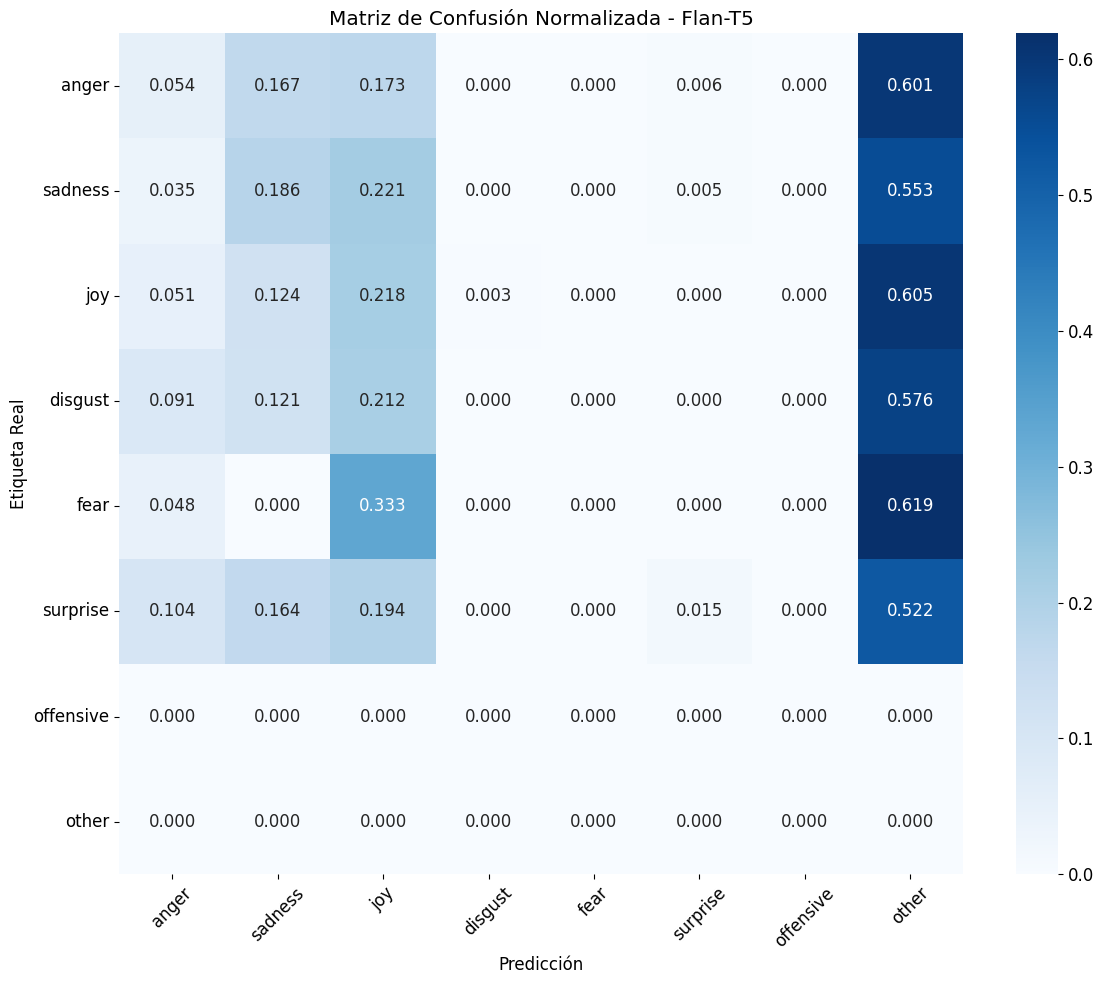

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def evaluate_t5_model():
    print("Evaluando modelo Flan-T5 en el conjunto de prueba...")

    # Asegurarse de que el modelo est√© en modo de evaluaci√≥n
    llm_model.eval()

    # Listas para almacenar las predicciones y las etiquetas verdaderas
    all_predictions = []
    all_true_labels = []


    # Definir las emociones v√°lidas para la limpieza de predicciones
    valid_emotions = ['anger', 'sadness', 'joy', 'disgust', 'fear', 'surprise', 'offensive', 'other']


    # Funci√≥n para limpiar y mapear las predicciones de texto a etiquetas v√°lidas
    def clean_prediction(pred_text):
        pred_clean = pred_text.strip().lower()
        # Si la predicci√≥n limpia es una emoci√≥n v√°lida, devolverla
        if pred_clean in valid_emotions:
            return pred_clean
        # Si no, buscar si alguna de las emociones v√°lidas est√° contenida en el texto de la predicci√≥n
        for emotion in valid_emotions:
            if emotion in pred_clean:
                return emotion
        # Si no se encuentra ninguna coincidencia, devolver 'other' por defecto
        return 'other'


    # Procesar las muestras en lotes para gestionar la memoria
    batch_size = 16
    total_samples = len(test_instruction_dataset)

    for i in range(0, total_samples, batch_size):
        end_idx = min(i + batch_size, total_samples)
        batch_texts = []
        batch_labels = []


        # Preparar el lote de textos y etiquetas
        for j in range(i, end_idx):
            batch_texts.append(test_instruction_dataset[j]['text'])
            batch_labels.append(test_instruction_dataset[j]['label'])

        try:
            # Tokenizar el lote de textos
            inputs = llm_tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=64
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}


            # Generar predicciones con el modelo
            with torch.no_grad():
                outputs = llm_model.generate(
                    **inputs,
                    max_length=8,
                    num_beams=4,
                    do_sample=False,
                    early_stopping=True,
                    pad_token_id=llm_tokenizer.pad_token_id,
                    eos_token_id=llm_tokenizer.eos_token_id
                )


            # Decodificar las predicciones generadas
            batch_predictions = llm_tokenizer.batch_decode(outputs, skip_special_tokens=True)


            # Limpiar y procesar cada predicci√≥n
            for pred_raw in batch_predictions:
                cleaned_pred = clean_prediction(pred_raw)
                all_predictions.append(cleaned_pred)


            # A√±adir las etiquetas verdaderas del lote a la lista general
            all_true_labels.extend(batch_labels)


            # Mostrar el progreso cada 100 muestras
            if (end_idx) % 100 == 0 or end_idx == total_samples:
                print(f"Procesado {end_idx}/{total_samples} muestras...")

        except Exception as e:
            print(f"Error en batch {i//batch_size + 1}: {e}")
            # En caso de error, a√±adir predicciones por defecto para mantener la consistencia
            for _ in range(len(batch_texts)):
                all_predictions.append('other')
            all_true_labels.extend(batch_labels)
            continue


    # Verificar que el n√∫mero de predicciones y etiquetas coincida
    if len(all_predictions) != len(all_true_labels):
        min_len = min(len(all_predictions), len(all_true_labels))
        all_predictions = all_predictions[:min_len]
        all_true_labels = all_true_labels[:min_len]
        print(f"Ajustadas longitudes a {min_len} muestras")


    # Mostrar algunos ejemplos de las predicciones
    print(f"\n--- Ejemplos de predicciones ---")
    for i in range(min(10, len(all_predictions))):
        print(f"Texto: {test_instruction_dataset[i]['text'][:100]}...")
        print(f"Real: {all_true_labels[i]} | Predicci√≥n: {all_predictions[i]}")
        print("-" * 50)


    # Calcular y mostrar las m√©tricas de clasificaci√≥n
    print(f"\n--- Reporte de Clasificaci√≥n para Flan-T5 ---")
    print(f"Total de muestras procesadas: {len(all_true_labels)}")


    # Verificar la distribuci√≥n de las predicciones y etiquetas reales
    from collections import Counter
    pred_dist = Counter(all_predictions)
    true_dist = Counter(all_true_labels)

    print(f"\nDistribuci√≥n de predicciones: {dict(pred_dist)}")
    print(f"Distribuci√≥n de etiquetas reales: {dict(true_dist)}")


    # Reporte de Clasificaci√≥n
    print("\n" + "="*60)
    report = classification_report(
        all_true_labels,
        all_predictions,
        labels=valid_emotions,
        target_names=valid_emotions,
        zero_division=0
    )
    print(report)


    # Matriz de Confusi√≥n
    try:
        cm = confusion_matrix(all_true_labels, all_predictions, labels=valid_emotions)


        # Normalizar la matriz de confusi√≥n para mostrar proporciones
        cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)


        # Crear el gr√°fico de la matriz de confusi√≥n
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized,
                   annot=True,
                   fmt='.3f',
                   cmap='Blues',
                   xticklabels=valid_emotions,
                   yticklabels=valid_emotions)
        plt.title('Matriz de Confusi√≥n Normalizada - Flan-T5')
        plt.xlabel('Predicci√≥n')
        plt.ylabel('Etiqueta Real')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error al crear matriz de confusi√≥n: {e}")

    return all_predictions, all_true_labels


# Ejecutar la funci√≥n de evaluaci√≥n
predictions, true_labels = evaluate_t5_model()

In [ ]:
import torch
from transformers import pipeline
import numpy as np
from tqdm import tqdm

print("Generando predicciones con el modelo Flan-T5 entrenado...")


# Cargar el modelo T5 afinado desde el directorio guardado
trained_model_path = './flan_t5_emotion_classifier'

try:
    # Intentar cargar el modelo desde la ruta guardada
    trained_model = T5ForConditionalGeneration.from_pretrained(trained_model_path)
    trained_tokenizer = T5Tokenizer.from_pretrained(trained_model_path)
    print("‚úì Modelo entrenado cargado exitosamente")
except:
    # Si falla, usar el modelo que est√° actualmente en memoria en el trainer
    trained_model = trainer_t5.model
    trained_tokenizer = llm_tokenizer
    print("‚úì Usando modelo del trainer actual")


# Mover el modelo al dispositivo (GPU o CPU)
trained_model = trained_model.to(device)
trained_model.eval()

def predict_emotion_t5(text, model, tokenizer, max_length=64):
    """Predice la emoci√≥n para un texto dado usando el modelo T5 afinado."""
    # Crear el prompt con el mismo formato que en el entrenamiento
    prompt = f"Classify emotion: {text}"


    # Tokenizar el texto de entrada
    inputs = tokenizer(
        prompt,
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device)


    # Generar la secuencia de salida (predicci√≥n)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=8,  # Longitud m√°xima para la etiqueta de emoci√≥n
            num_beams=4,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )


    # Decodificar la predicci√≥n a texto plano
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return prediction.strip()


# Generar predicciones para todo el conjunto de prueba
print("Generando predicciones para el conjunto de prueba...")
final_predictions_t5 = []


# Usar tqdm para visualizar el progreso de la generaci√≥n
for i, row in tqdm(test_df_cleaned.iterrows(), total=len(test_df_cleaned), desc="Predicciones"):
    try:
        prediction = predict_emotion_t5(row['text_clean'], trained_model, trained_tokenizer)
        final_predictions_t5.append(prediction)
    except Exception as e:
        print(f"Error en predicci√≥n {i}: {e}")
        # En caso de error, registrar una predicci√≥n por defecto
        final_predictions_t5.append("neutral")

print(f"‚úì Predicciones completadas: {len(final_predictions_t5)}")


# Verificar algunas de las predicciones generadas
print("\n--- Verificaci√≥n de predicciones ---")
for i in range(min(5, len(test_df_cleaned))):
    print(f"Texto: {test_df_cleaned.iloc[i]['text_clean'][:100]}...")
    print(f"Emoci√≥n real: {test_df_cleaned.iloc[i]['emotion']}")
    print(f"Predicci√≥n: {final_predictions_t5[i]}")
    print("-" * 50)


# Calcular y mostrar estad√≠sticas b√°sicas de las predicciones
from collections import Counter
prediction_counts = Counter(final_predictions_t5)
print("\n--- Distribuci√≥n de predicciones ---")
for emotion, count in prediction_counts.most_common():
    print(f"{emotion}: {count} ({count/len(final_predictions_t5)*100:.1f}%)")

print(f"\nPredicciones √∫nicas encontradas: {len(prediction_counts)}")
print("¬°Predicciones generadas exitosamente! Ahora puedes ejecutar el an√°lisis por eventos.")

Generando predicciones con el modelo Flan-T5 entrenado...
‚úì Modelo entrenado cargado exitosamente
Generando predicciones para el conjunto de prueba...


Predicciones: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1656/1656 [01:30<00:00, 18.23it/s]

‚úì Predicciones completadas: 1656

--- Verificaci√≥n de predicciones ---
Texto: se√±or de luz, ven a nosotros en nuestra oscuridad. te ofrecemos estos falsos dioses, t√≥malos e ilum√≠...
Emoci√≥n real: others
Predicci√≥n: sadness
--------------------------------------------------
Texto: pues ya hemos votado tanto mi madre y yo #eleccionesgenerales28a...
Emoci√≥n real: others
Predicci√≥n: others
--------------------------------------------------
Texto: #diadellibro üòá‚≠ê‚ù§Ô∏èüôèüôåüòçüå∑ sentimientos, viajar con la imaginaci√≥n ‚≠ê‚≠ê https://t.co/gmghmzlg6z...
Emoci√≥n real: joy
Predicci√≥n: others
--------------------------------------------------
Texto: ¬°feliz #d√≠adellibroüìö! ‚Äùel libro es fuerza, es valor, es poder, es alimento; antorcha del pensamiento...
Emoci√≥n real: joy
Predicci√≥n: joy
--------------------------------------------------
Texto: pues qu√© quer√©is que os diga, este sarao pol√≠tico, me gusta! momentos como este, en los que se movil...
Emoci√≥n real: j

In [ ]:
# Realizar an√°lisis de rendimiento por evento para Flan-T5
test_results_df_t5 = test_df_cleaned.copy()
test_results_df_t5['predicted_emotion'] = final_predictions_t5
test_results_df_t5['correct_prediction'] = (test_results_df_t5['emotion'] == test_results_df_t5['predicted_emotion'])

event_performance_t5 = test_results_df_t5.groupby('event')['correct_prediction'].agg(['count', 'sum', 'mean']).round(4)
event_performance_t5.columns = ['total_tweets', 'correct_predictions', 'accuracy']
event_performance_t5 = event_performance_t5.sort_values('accuracy', ascending=False)

significant_events_t5 = event_performance_t5[event_performance_t5['total_tweets'] >= 2]

if not significant_events_t5.empty:
    print("=== RENDIMIENTO POR EVENTO (‚â•2 tweets) - Flan-T5 ===")
    print(f"Eventos analizados: {len(significant_events_t5)}")
    display(significant_events_t5)
else:
    print("No hay eventos con 2 o m√°s tweets en el conjunto de prueba para un an√°lisis significativo.")

=== RENDIMIENTO POR EVENTO (‚â•2 tweets) - Flan-T5 ===
Eventos analizados: 8


total_tweets  correct_predictions  accuracy
event                                                       
GretaThunberg             139                   63    0.4532
Venezuela                 234                  103    0.4402
LaLiga                    119                   45    0.3782
ChampionsLeague           232                   86    0.3707
WorldBookDay              240                   86    0.3583
SpainElection             218                   77    0.3532
GameOfThrones             219                   74    0.3379
NotreDame                 225                   31    0.1378

## 9. Evaluaci√≥n de los modelos